___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2025

___
### Import libraries and sub-libraries.

In [45]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import torch.nn.functional as F
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from tqdm.notebook import tqdm
import datetime
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [46]:
# from fontsetting import font_cmu
# plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)

Device available: cuda


___
### Read training data from `data/train/hig-res` and `data/train/low-res`


In [48]:
class TIFFDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, transform=None, augment=False, dataset_name="Dataset"):
        self.high_res_dir = high_res_dir
        self.low_res_dir = low_res_dir
        self.transform = transform
        self.augment = augment
        self.dataset_name = dataset_name
        self.original_filenames = sorted([f for f in os.listdir(high_res_dir) if f.endswith('.tif')])
        self.num_original_images = len(self.original_filenames)

        self.low_res_images = []
        self.high_res_images = []

        for filename in self.original_filenames:
            high_res_path = os.path.join(self.high_res_dir, filename)
            low_res_path = os.path.join(self.low_res_dir, filename)

            # Load original images
            try:
                hr_img = Image.open(high_res_path)
                lr_img = Image.open(low_res_path)
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
                continue

            # Resize low-res to 128x128
            lr_img = lr_img.resize((128, 128), Image.BICUBIC)

            original_lr, original_hr = lr_img, hr_img
            processed_lr = []
            processed_hr = []

            if self.augment:
                # --- Apply transformations ---
                # 1) Original
                processed_lr.append(original_lr)
                processed_hr.append(original_hr)
                # 2) Rotated by 90 degrees
                processed_lr.append(original_lr.rotate(90))
                processed_hr.append(original_hr.rotate(90))
                # 3) Rotated by 180 degrees
                processed_lr.append(original_lr.rotate(180))
                processed_hr.append(original_hr.rotate(180))
                # 4) Rotated by 270 degrees
                processed_lr.append(original_lr.rotate(270))
                processed_hr.append(original_hr.rotate(270))

                # Apply flips
                lr_v_flip = original_lr.transpose(Image.FLIP_LEFT_RIGHT)
                hr_v_flip = original_hr.transpose(Image.FLIP_LEFT_RIGHT)
                lr_h_flip = original_lr.transpose(Image.FLIP_TOP_BOTTOM)
                hr_h_flip = original_hr.transpose(Image.FLIP_TOP_BOTTOM)

                # 5) Mirrored on the vertical axis (Flip Left/Right)
                processed_lr.append(lr_v_flip)
                processed_hr.append(hr_v_flip)
                # 6) Mirrored on the horizontal axis (Flip Top/Bottom)
                processed_lr.append(lr_h_flip)
                processed_hr.append(hr_h_flip)

                # Apply flips combined with rotation (unique combinations)
                # 7) Rotated by 90 degrees and mirrored on the vertical axis
                processed_lr.append(lr_v_flip.rotate(90))
                processed_hr.append(hr_v_flip.rotate(90))
                # 8) Rotated by 90 degrees and mirrored on the horizontal axis
                processed_lr.append(lr_h_flip.rotate(90))
                processed_hr.append(hr_h_flip.rotate(90))
            else:
                # If not augmenting, just use the original
                processed_lr.append(original_lr)
                processed_hr.append(original_hr)

            # Apply the final transform (ToTensor) and store
            if self.transform:
                for lr, hr in zip(processed_lr, processed_hr):
                    self.low_res_images.append(torch.clamp(self.transform(lr), min=0.0, max=1.0))
                    self.high_res_images.append(torch.clamp(self.transform(hr), min=0.0, max=1.0))
            else:
                 # If no transform, store PIL images (not recommended for training/eval)
                self.low_res_images.extend(processed_lr)
                self.high_res_images.extend(processed_hr)

    # Get the number of samples in the dataset (original or augmented)
    def __len__(self):
        return len(self.low_res_images)

    # Get the sample at the given index
    def __getitem__(self, idx):
        # Return pre-processed tensors
        return self.low_res_images[idx], self.high_res_images[idx]
    
    def verify_clamped_values(self):
        """
        Verifies the min/max values of the loaded and clamped tensors.
        """
        print(f"\n--- Verifying Clamped Values for {self.dataset_name} ---")
        if not self.low_res_images or not self.high_res_images:
            print("No images loaded to verify.")
            return

        min_lr, max_lr = float('inf'), float('-inf')
        min_hr, max_hr = float('inf'), float('-inf')

        # Check low-resolution images
        for tensor in self.low_res_images:
            current_min_lr = torch.min(tensor).item()
            current_max_lr = torch.max(tensor).item()
            if current_min_lr < min_lr: min_lr = current_min_lr
            if current_max_lr > max_lr: max_lr = current_max_lr

        # Check high-resolution images
        for tensor in self.high_res_images:
            current_min_hr = torch.min(tensor).item()
            current_max_hr = torch.max(tensor).item()
            if current_min_hr < min_hr: min_hr = current_min_hr
            if current_max_hr > max_hr: max_hr = current_max_hr

        print(f"Low-Res Images (Clamped): Min={min_lr:.8f}, Max={max_lr:.8f}")
        print(f"High-Res Images (Clamped): Min={min_hr:.8f}, Max={max_hr:.8f}")
        print("----------------------------------------------")

# Function to create data loader
def create_loader(dataset, batch_size, shuffle_data=True): # Added shuffle parameter
    torch.manual_seed(0)  # For reproducibility
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_data)

### Create a custom loss class to easily implement custom loss functions.

In [49]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, device='cpu'):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha # Weight for MSE (PSNR) loss
        self.beta = beta # Weight for SSIM loss
        self.mse = nn.MSELoss()
        self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
        self.device = device

    def forward(self, y_pred, y_true):
        # Ensure inputs are on the same device as the ssim metric
        y_pred = y_pred.to(self.device)
        y_true = y_true.to(self.device)

        # Calculate MSE Loss
        mse_loss = self.mse(y_pred, y_true)

        # Calculate SSIM Loss (1 - SSIM, as SSIM higher is better)
        y_pred_clamped = torch.clamp(y_pred, 0.0, 1.0)
        ssim_val = self.ssim(y_pred_clamped, y_true)
        ssim_val_clamped = torch.clamp(ssim_val, min=-1.0, max=1.0)
        ssim_loss = 1.0 - ssim_val_clamped

        # Combine losses
        combined_loss = (self.alpha * mse_loss) + (self.beta * ssim_loss)

        return combined_loss

___
### Define a super-resolution network

In [50]:
class SuperResolutionNet(nn.Module):
    def __init__(self):
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=True)
        upscale_factor = 2
        channels_mult = upscale_factor * upscale_factor # = 4

        # --- Initial Feature Extraction ---
        # Input: 1 x 128 x 128
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=80, kernel_size=3, padding=1) # 80 x 128 x 128
        self.conv1b = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80 x 128 x 128

        # --- Upscaling Path 1 (128 -> 256) using PixelShuffle ---
        # Main Path
        self.upscale1_conv = nn.Conv2d(in_channels=80, out_channels=80 * channels_mult, kernel_size=3, padding=1) # 80*4 x 128 x 128
        self.pixel_shuffle1 = nn.PixelShuffle(upscale_factor) # -> 80 x 256 x 256
        self.conv2 = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80 x 256 x 256
        self.conv2b = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80 x 256 x 256
        # Skip Path 1 (Interpolate features from 128x128 stage)
        self.bskip1 = nn.Upsample(scale_factor=upscale_factor, mode='bicubic', align_corners=False) # Interpolates 80 channels to 256x256
        # Convolution after combining skip connection 1 (Input channels = 80 from main path + 80 from skip = 160)
        self.conv_after_skip1 = nn.Conv2d(in_channels=160, out_channels=80, kernel_size=3, padding=1) # 160x256x256 -> 80x256x256
        self.conv_after_skip1b = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80x256x256

        # --- Upscaling Path 2 (256 -> 512) using PixelShuffle & Widened Middle ---
        # Main Path
        self.upscale2_conv = nn.Conv2d(in_channels=80, out_channels=80 * channels_mult, kernel_size=3, padding=1) # 80*4 x 256 x 256 (Widened)
        self.pixel_shuffle2 = nn.PixelShuffle(upscale_factor) # -> 80 x 512 x 512 (Widened)
        self.conv3 = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80 x 512 x 512 (Widened)
        self.conv3b = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80 x 512 x 512 (Widened)
        # Skip Path 2 (Interpolate features from 256x256 stage after conv_after_skip1b)
        self.bskip2 = nn.Upsample(scale_factor=upscale_factor, mode='bicubic', align_corners=False) # Interpolates 80 channels to 512x512
        # Convolution after combining skip connection 2 (Input channels = 80 from main path + 80 from skip = 160) (Widened)
        self.conv_after_skip2 = nn.Conv2d(in_channels=160, out_channels=80, kernel_size=3, padding=1) # 160x512x512 -> 80x512x512 (Widened)
        self.conv_after_skip2b = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80x512x512 (Widened)

        # --- Downscaling Path (512 -> 256) ---
        # Input channel matches the widened middle stage (80)
        self.downscale = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=2, stride=2) # 80x512x512 -> 80x256x256
        self.conv4 = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80x256x256
        self.conv4b = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80x256x256

        # --- Final Output Layer ---
        # Takes the output of the downscaling path (80 channels) and maps to 1 channel
        self.conv_out_final = nn.Conv2d(in_channels=80, out_channels=1, kernel_size=3, padding=1) # 80x256x256 -> 1x256x256

    def forward(self, x):
        # x: Input 1 x 128 x 128

        # --- Initial Feature Extraction ---
        features128 = self.relu(self.conv1(x))
        features128 = self.relu(self.conv1b(features128)) # 80 x 128 x 128

        # --- Upscaling Path 1 + Skip Connection 1 ---
        # Calculate interpolated skip features first
        skip1_interpolated = self.bskip1(features128) # 80 x 256 x 256
        # Main path upscale using PixelShuffle
        up1_conv_out = self.upscale1_conv(features128) # 80*4 x 128 x 128
        up1_out = self.pixel_shuffle1(up1_conv_out)    # 80 x 256 x 256
        features256_main = self.relu(self.conv2(up1_out))
        features256_main = self.relu(self.conv2b(features256_main)) # 80 x 256 x 256
        # Concatenate main path features and interpolated skip features
        concat1 = torch.cat((features256_main, skip1_interpolated), dim=1) # 160 x 256 x 256
        # Process combined features
        features256_processed = self.relu(self.conv_after_skip1(concat1))
        features256_processed = self.relu(self.conv_after_skip1b(features256_processed)) # 80 x 256 x 256

        # --- Upscaling Path 2 + Skip Connection 2 ---
        # Calculate interpolated skip features (using output from conv_after_skip1b)
        skip2_interpolated = self.bskip2(features256_processed) # 80 x 512 x 512
        # Main path upscale using PixelShuffle (Widened Middle)
        up2_conv_out = self.upscale2_conv(features256_processed) # 80*4 x 256 x 256
        up2_out = self.pixel_shuffle2(up2_conv_out)    # 80 x 512 x 512
        features512_main = self.relu(self.conv3(up2_out))
        features512_main = self.relu(self.conv3b(features512_main)) # 80 x 512 x 512
        # Concatenate main path features and interpolated skip features
        concat2 = torch.cat((features512_main, skip2_interpolated), dim=1) # 160 x 512 x 512
        # Process combined features
        features512_processed = self.relu(self.conv_after_skip2(concat2))
        features512_processed = self.relu(self.conv_after_skip2b(features512_processed)) # 80 x 512 x 512

        # --- Downscaling Path ---
        down_out = self.downscale(features512_processed) # 80 x 256 x 256
        features256_final = self.relu(self.conv4(down_out))
        features256_final = self.relu(self.conv4b(features256_final)) # 80 x 256 x 256

        # --- Final Output Layer ---
        output = self.conv_out_final(features256_final) # 1 x 256 x 256

        return output

___
### Create a function to execute training. Note, we will call this function later.

In [51]:
# Helper function for one training epoch
def train_one_epoch(model, train_loader, criterion, optimizer, device, scaler):
    model.train() # Set model to training mode
    total_train_loss = 0.0
    for x_tr_batch, y_tr_batch in train_loader:
        x_tr_batch, y_tr_batch = x_tr_batch.to(device), y_tr_batch.to(device)

        optimizer.zero_grad()

        # --- Mixed Precision: Forward pass with autocast ---
        with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=scaler.is_enabled()):
            y_hat_tr_batch = model(x_tr_batch)
            loss = criterion(y_hat_tr_batch, y_tr_batch)

        # --- Mixed Precision: Scale loss and backward pass ---
        scaler.scale(loss).backward()

        # --- Mixed Precision: Scaler step and update ---
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    return avg_train_loss

# Helper function for one validation epoch
def validate_one_epoch(model, val_loader, criterion, psnr_metric, ssim_metric, device):
    model.eval() # Set model to evaluation mode
    total_val_loss = 0.0
    total_val_psnr = 0.0
    total_val_ssim = 0.0
    num_samples = 0

    with torch.no_grad():
        for x_val_batch, y_val_batch in val_loader:
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
            batch_size = x_val_batch.size(0)
            num_samples += batch_size

            # Upsample low-resolution input for baseline comparison (outside autocast if not needed)
            x_val_batch_interpolated = torch.nn.functional.interpolate(x_val_batch, scale_factor=2, mode='bicubic', align_corners=False)

            # --- Mixed Precision: Validation forward pass with autocast ---
            # Enable autocast for potential efficiency, disable if it causes issues with metrics/loss
            with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=True):
                y_hat_val_batch = model(x_val_batch)
                # Ensure loss calculation happens with autocast output type or cast explicitly if needed
                val_loss = criterion(y_hat_val_batch, y_val_batch)

            total_val_loss += val_loss.item() * batch_size # Accumulate total loss

            # Calculate metrics (ensure they handle potential float16 inputs from autocast)
            # TorchMetrics usually handles this, but double-check if using custom metrics.
            # Cast inputs to float32 if metrics require it:
            # psnr = psnr_metric(y_hat_val_batch.float(), y_val_batch.float())
            # ssim = ssim_metric(y_hat_val_batch.float(), y_val_batch.float())
            psnr = psnr_metric(y_hat_val_batch, y_val_batch)
            ssim = ssim_metric(y_hat_val_batch, y_val_batch)

            total_val_psnr += psnr.item() * batch_size
            total_val_ssim += ssim.item() * batch_size

    avg_val_loss = total_val_loss / num_samples # Average loss per image
    avg_val_psnr = total_val_psnr / num_samples
    avg_val_ssim = total_val_ssim / num_samples
    avg_val_score = avg_val_psnr + (40 * avg_val_ssim)

    return avg_val_loss, avg_val_score, avg_val_psnr, avg_val_ssim

def train_model(model, opt, criterion, scheduler, train_loader, val_loader, num_epoch, patience, device, save_dir='saved_models', scaler=None):
    os.makedirs(save_dir, exist_ok=True)
    epoch_nums, avg_train_losses, avg_val_losses, avg_val_scores = [], [], [], []
    best_val_score = -float('inf')
    epochs_no_improve = 0
    best_model_state = None

    # Initialize metrics outside the loop - ensure they handle accumulation correctly or reset them if needed
    # For torchmetrics, calling them per batch and averaging manually is often safer than relying on internal state across epochs.
    # We will re-initialize inside validate_one_epoch for clarity here.
    psnr_metric = PeakSignalNoiseRatio().to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device) # data_range=1.0 assumes normalization

    overall_pbar = tqdm(range(num_epoch), desc="Overall Training Progress")

    for epoch in overall_pbar:
        # --- Training ---
        avg_train_loss = train_one_epoch(model, train_loader, criterion, opt, device, scaler)

        # --- Validation ---
        avg_val_loss, avg_val_score, avg_val_psnr, avg_val_ssim = validate_one_epoch(
            model, val_loader, criterion, psnr_metric, ssim_metric, device
        )

        # Store metrics for plot
        epoch_nums.append(epoch + 1)
        avg_train_losses.append(avg_train_loss)
        avg_val_losses.append(avg_val_loss)
        avg_val_scores.append(avg_val_score)

        # --- Update Progress Bar ---
        current_lr = opt.param_groups[0]['lr']
        overall_pbar.set_description(
            f"LR: {current_lr:.1e} | Train Loss: {avg_train_loss:.4f} | Current Val Score: {avg_val_score:.2f} | Best Val Score: {best_val_score:.2f} | Epochs Since Best: {epochs_no_improve:.0f}"
        )

        # --- Learning Rate Scheduler Step ---
        scheduler.step(avg_val_score)

        # --- Checkpointing and Early Stopping ---
        if avg_val_score > best_val_score:
            best_val_score = avg_val_score
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
            # Optionally add a print statement here if desired
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs with no improvement.")
            break

    # --- Save Best Model ---
    if best_model_state:
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        score_str = f"{best_val_score:.2f}".replace('.', 'p')
        filename = f"best_model_score_{score_str}_time_{timestamp}.pth"
        save_path = os.path.join(save_dir, filename)
        torch.save(best_model_state, save_path)
        print(f"\nTraining finished. Best model saved to '{save_path}' with score: {best_val_score:.2f}")
        model.load_state_dict(best_model_state) # Load best state into model
    else:
        print("\nTraining finished. No model state was saved.")

    # --- Final Plot ---
    fig_final, ax1_final = plt.subplots(figsize=(10, 6))
    ax2_final = ax1_final.twinx()
    line1_final, = ax1_final.plot(epoch_nums, avg_train_losses, 'r-', label='Training Loss')
    line2_final, = ax1_final.plot(epoch_nums, avg_val_losses, 'r--', label='Validation Loss')
    line3_final, = ax2_final.plot(epoch_nums, avg_val_scores, 'b-', label='Validation Score')
    ax1_final.set_xlabel('Epochs')
    ax1_final.set_ylabel('Loss', color='tab:red')
    ax1_final.tick_params(axis='y', labelcolor='tab:red')
    ax2_final.set_ylabel('Validation Score (PSNR + 40*SSIM)', color='tab:blue')
    ax2_final.tick_params(axis='y', labelcolor='tab:blue')
    ax1_final.legend(handles=[line1_final, line2_final], loc='upper left')
    ax2_final.legend(handles=[line3_final], loc='upper right')
    ax1_final.grid(True)
    plt.title('Final Training Progress')
    fig_final.tight_layout()
    plt.show()

    return best_val_score

___
### Now, let us define hyperparameters and train the network. 


--- Verifying Clamped Values for Training Set ---
Low-Res Images (Clamped): Min=0.00000000, Max=0.91556430
High-Res Images (Clamped): Min=0.00000000, Max=1.00000000
----------------------------------------------

--- Verifying Clamped Values for Validation Set ---
Low-Res Images (Clamped): Min=0.00000000, Max=0.92179400
High-Res Images (Clamped): Min=0.00000000, Max=0.99313724
----------------------------------------------
Number of original training images: 270
Number of training images after augmentation: 2160
Number of original validation images: 30
Number of validation images (no augmentation): 30


Overall Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]


Early stopping triggered after 25 epochs with no improvement.

Training finished. Best model saved to 'saved_models\best_model_score_75p48_time_20250426_030418.pth' with score: 75.48


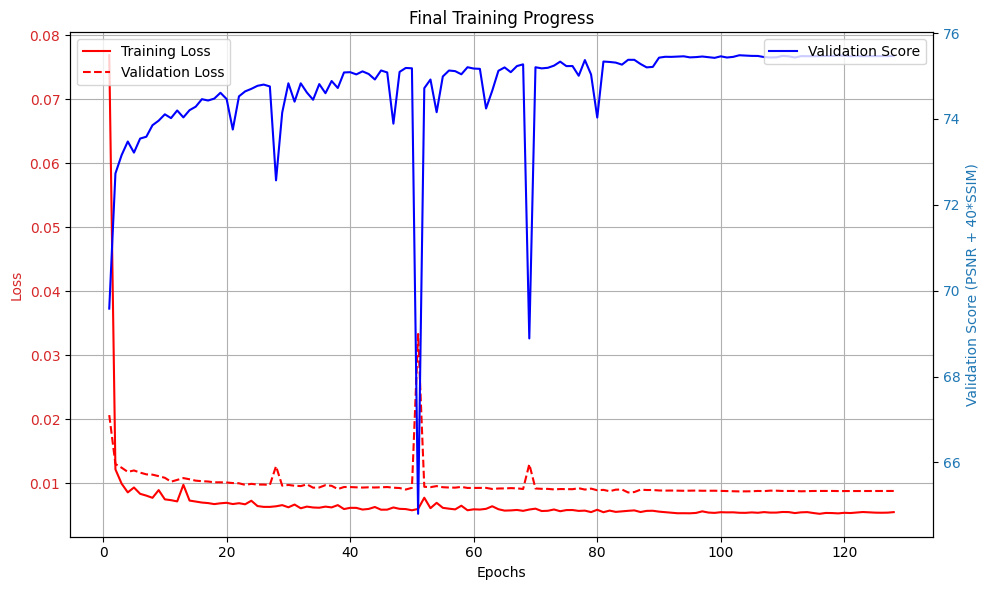


Best validation score achieved during training: 75.48


In [ ]:
# --- Hyperparameters ---
batch_size = 8
lr = 1e-4
num_epoch = 200
patience_early_stopping = 25
scheduler_patience = 10
scheduler_factor = 0.05
loss_alpha = 0.6
loss_beta = 0.4
save_dir = 'saved_models'

# --- Setup ---
# Define a transform to convert images to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor()])
# Create the dataset for images
train_dataset = TIFFDataset('data/train/high-res', 'data/train/low-res', transform=transform, augment=True, dataset_name="Training Set")
val_dataset = TIFFDataset('data/test/high-res', 'data/test/low-res', transform=transform, augment=False, dataset_name="Validation Set")
# Verify that all data are normalized
train_dataset.verify_clamped_values()
val_dataset.verify_clamped_values()
# Create DataLoaders
train_loader = create_loader(train_dataset, batch_size, shuffle_data=True)
val_loader = create_loader(val_dataset, batch_size, shuffle_data=False)
# Print dataset sizes
if 'train_dataset' in locals() and 'val_dataset' in locals():
    print(f'Number of original training images: {getattr(train_dataset, "num_original_images", "N/A")}')
    print(f'Number of training images after augmentation: {len(train_dataset)}')
    print(f'Number of original validation images: {getattr(val_dataset, "num_original_images", "N/A")}')
    print(f'Number of validation images (no augmentation): {len(val_dataset)}')

# Model
model = SuperResolutionNet().to(device)
scaler = torch.amp.GradScaler('cuda')

# Optimizer
opt = optim.Adam(model.parameters(), lr=lr)

# Loss Function (Criterion)
criterion = CombinedLoss(alpha=loss_alpha, beta=loss_beta, device=device).to(device)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(
    opt,
    mode='max',
    factor=scheduler_factor,
    patience=scheduler_patience
)

# --- Train the model ---
best_score = train_model(
    model=model,
    opt=opt,
    criterion=criterion,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epoch=num_epoch,
    patience=patience_early_stopping,
    device=device,
    save_dir=save_dir,
    scaler=scaler
)

print(f"\nBest validation score achieved during training: {best_score:.2f}")

### Aside for trivialnet

In [75]:
class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)  # First conv layer
        x = self.conv2(x)  # Output layer
        return x
    
trivial_model = TrivialNet().to(device)
trivial_model.load_state_dict(torch.load("trivial.pth")) # Load the state dict from the trained model

<All keys matched successfully>

___
### Apply it one of the validation image

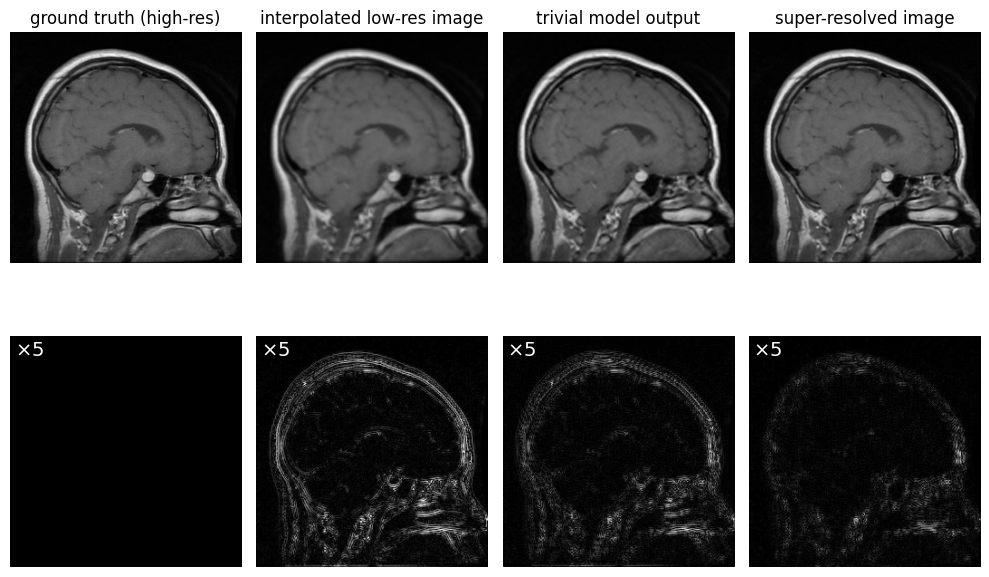

In [80]:
val_dataset = TIFFDataset('data/test/high-res', 'data/test/low-res', transform=transform, augment=False, dataset_name="Validation Set")

# Load one (low-res, high-res) image pair from validation dataset and move it to the dedvice
val_low_res, val_high_res = val_dataset[1]  # Input (128x128), Ground truth (256x256)
val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

# Keep the interpolated version ONLY for visualization comparison
val_low_res_interpolated = torch.nn.functional.interpolate(val_low_res.unsqueeze(0), scale_factor=2, mode='bicubic', align_corners=False).squeeze(0)

# Apply the trained model to the original low-res image
# Add batch dimension for model, then remove it and detach
val_trivial_res = trivial_model(val_low_res_interpolated.unsqueeze(0)).detach().squeeze(0)
val_super_res = model(val_low_res.unsqueeze(0)).detach().squeeze(0)

# Convert tensors to numpy for visualization
val_low_res_np = val_low_res_interpolated.squeeze().cpu().numpy()  # Use the interpolated version for vis/error maps
val_high_res_np = val_high_res.squeeze().cpu().numpy()
val_super_res_np = val_super_res.squeeze().cpu().numpy()
val_trivial_res_np = val_trivial_res.squeeze().cpu().numpy()

# Plot an example image and error maps
fig, ax = plt.subplots(2, 4, figsize=(10, 7))

# Plot images
ax[0, 0].imshow(val_high_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('ground truth (high-res)')
ax[0, 0].axis('off')

ax[0, 1].imshow(val_low_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('interpolated low-res image')
ax[0, 1].axis('off')

ax[0, 2].imshow(val_trivial_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('trivial model output')
ax[0, 2].axis('off')

ax[0, 3].imshow(val_super_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 3].set_title('super-resolved image')
ax[0, 3].axis('off')

# Error maps
ax[1, 0].imshow(5 * np.abs(val_high_res_np - val_high_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(5 * np.abs(val_high_res_np - val_low_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(5 * np.abs(val_high_res_np - val_trivial_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 3].imshow(5 * np.abs(val_high_res_np - val_super_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 3].axis('off')
ax[1, 3].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 3].transAxes, fontsize=14, va='top', ha='left', color='white')

plt.tight_layout()
plt.show()

### Compute PSNR and SSIM over the entire training dataset

In [64]:
val_dataset = TIFFDataset('data/train/high-res', 'data/train/low-res', transform=transform, augment=False, dataset_name="Validation Set")
val_loader = create_loader(val_dataset, batch_size, shuffle_data=False)

def evaluate_model(model, data_loader, device):
    """Computes PSNR, SSIM, and Score over a dataset using a DataLoader."""
    model.eval() # Set model to evaluation mode
    psnr_metric = PeakSignalNoiseRatio().to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    total_psnr_sr = 0.0
    total_ssim_sr = 0.0
    total_psnr_interp = 0.0
    total_ssim_interp = 0.0
    num_samples = 0

    with torch.no_grad():
        eval_pbar = tqdm(data_loader, desc="Evaluating Model")
        for x_batch, y_batch in eval_pbar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device) # x_batch is 128x128
            batch_size_actual = x_batch.size(0)
            num_samples += batch_size_actual

            # Keep this interpolation for baseline calculation (outside autocast)
            x_batch_interpolated = torch.nn.functional.interpolate(x_batch, scale_factor=2, mode='bicubic', align_corners=False)

            # --- Mixed Precision: Evaluation forward pass with autocast ---
            # Enable autocast for potential efficiency
            with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=True):
                y_hat_batch = model(x_batch) # Model outputs 256x256

            # Calculate metrics for super-resolved
            # Cast inputs to float32 if metrics require it:
            # psnr_sr = psnr_metric(y_hat_batch.float(), y_batch.float())
            # ssim_sr = ssim_metric(y_hat_batch.float(), y_batch.float())
            psnr_sr = psnr_metric(y_hat_batch, y_batch)
            ssim_sr = ssim_metric(y_hat_batch, y_batch)
            total_psnr_sr += psnr_sr.item() * batch_size_actual
            total_ssim_sr += ssim_sr.item() * batch_size_actual

            # Calculate metrics for interpolated (baseline) - ensure y_batch is float32 if needed
            psnr_interp = psnr_metric(x_batch_interpolated, y_batch)
            ssim_interp = ssim_metric(x_batch_interpolated, y_batch)
            total_psnr_interp += psnr_interp.item() * batch_size_actual
            total_ssim_interp += ssim_interp.item() * batch_size_actual

    # Calculate averages
    avg_psnr_sr = total_psnr_sr / num_samples
    avg_ssim_sr = total_ssim_sr / num_samples
    avg_psnr_interp = total_psnr_interp / num_samples
    avg_ssim_interp = total_ssim_interp / num_samples

    # Calculate scores
    avg_score_sr = avg_psnr_sr + (40 * avg_ssim_sr)
    avg_score_interp = avg_psnr_interp + (40 * avg_ssim_interp)

    # Print results
    print("\n--- Final Evaluation Results ---")
    print(f'Average PSNR (interpolated): {avg_psnr_interp:.2f} dB')
    print(f'Average PSNR (super-resolved): {avg_psnr_sr:.2f} dB')
    print(f'Average SSIM (interpolated): {avg_ssim_interp:.4f}')
    print(f'Average SSIM (super-resolved): {avg_ssim_sr:.4f}')
    print(f'Average Score (interpolated): {avg_score_interp:.2f}')
    print(f'Average Score (super-resolved): {avg_score_sr:.2f}')

    return avg_score_sr, avg_score_interp

# --- Call the Evaluation Function ---
final_sr_score, final_interp_score = evaluate_model(model, val_loader, device)

Evaluating Model:   0%|          | 0/30 [00:00<?, ?it/s]


--- Final Evaluation Results ---
Average PSNR (interpolated): 30.50 dB
Average PSNR (super-resolved): 36.02 dB
Average SSIM (interpolated): 0.9116
Average SSIM (super-resolved): 0.9669
Average Score (interpolated): 66.96
Average Score (super-resolved): 74.69


### Compute PSNR and SSIM over the entire validation dataset

In [62]:
val_dataset = TIFFDataset('data/val/high-res', 'data/val/low-res', transform=transform, augment=False, dataset_name="Validation Set")
val_loader = create_loader(val_dataset, batch_size, shuffle_data=False)

# --- Call the Evaluation Function ---
final_sr_score, final_interp_score = evaluate_model(model, val_loader, device)

Evaluating Model:   0%|          | 0/4 [00:00<?, ?it/s]


--- Final Evaluation Results ---
Average PSNR (interpolated): 31.00 dB
Average PSNR (super-resolved): 36.63 dB
Average SSIM (interpolated): 0.9074
Average SSIM (super-resolved): 0.9655
Average Score (interpolated): 67.30
Average Score (super-resolved): 75.25


### Compute PSNR and SSIM over the entire test dataset

In [63]:
val_dataset = TIFFDataset('data/test/high-res', 'data/test/low-res', transform=transform, augment=False, dataset_name="Validation Set")
val_loader = create_loader(val_dataset, batch_size, shuffle_data=False)

# --- Call the Evaluation Function ---
final_sr_score, final_interp_score = evaluate_model(model, val_loader, device)

Evaluating Model:   0%|          | 0/4 [00:00<?, ?it/s]


--- Final Evaluation Results ---
Average PSNR (interpolated): 30.80 dB
Average PSNR (super-resolved): 36.61 dB
Average SSIM (interpolated): 0.9192
Average SSIM (super-resolved): 0.9717
Average Score (interpolated): 67.57
Average Score (super-resolved): 75.48
